# Install packages

In [1]:
# Uncomment and run the cell to install packages
# !pip install numpy scipy scikit-learn matplotlib 'fairlearn==0.4.1' POT joblib

# Create a folder named 'results_synth' in working directory to store results

In [1]:
import numpy as np
from collections import namedtuple, Counter
import ot
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV
from fairlearn.reductions import GridSearch, ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds, DemographicParity #, TruePositiveRateDifference
from fairlearn.metrics import group_recall_score, group_specificity_score
import matplotlib.pyplot as plt
import pickle
from numpy import linalg
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import rbf_kernel
import multiprocessing
from joblib import Parallel, delayed

np.random.seed(101)

# Generate simulation data

In [2]:
def random_logit(x):
    z = 1./(1+np.exp(-x))
    s = np.random.binomial(n=1, p=z)

    return 2*s-1

def gen_synth_shift_data(gamma_shift_src=[0.0], gamma_shift_tar=[0.0], gamma_A=0.0, C_src=0, C_tar=1, N=1000, verbose=False):
    '''Flu classification example
    Variables
    C: context 0 or 1
    A: age group 0 or 1
    R: risk
    T: temperature
    Y: flu 0 or 1'''
    
    # Regression coefficients
    gamma_AC = 0.2
    gamma_TC = 0.2

    gamma_RA = -0.1
    gamma_YA = -0.8
    gamma_YR = 0.8
    gamma_TY = 0.8
    gamma_TR = 0.1
    gamma_TA = -0.8
    
    scale_T = 1.0
    scale_e = 0.64
    scale_A = 1.0
    scale_Y = 1.0
    
    # Source datasets
    data_src = []
    for gamma_shift in gamma_shift_src:
        C_src_vec = np.repeat(a=C_src,repeats=N)
        A = random_logit(scale_A*(gamma_A + gamma_shift*gamma_AC*C_src_vec + np.random.normal(loc=0.0, scale=scale_e, size=N)))
        R = gamma_RA*A + np.random.normal(loc=0.0, scale=1+scale_e, size=N) # N(0,1)
        Y_src = random_logit(scale_Y*(gamma_YA*A + gamma_YR*R + np.random.normal(loc=0.0, scale=scale_e, size=N)))
        T = gamma_TY*Y_src + gamma_TR*R + gamma_TA*A + np.random.normal(loc=0.0, scale=scale_T+gamma_shift*gamma_TC*C_src_vec, size=N)

        Y_src = (Y_src+1)/2
        X_src = np.stack([A, R, T], axis=1)
        data_src.append((gamma_shift,X_src,Y_src))

    # Target datasets
    data_tar = []
    for gamma_shift in gamma_shift_tar:
        C_tar_vec = np.repeat(a=C_tar,repeats=N)
        A = random_logit(scale_A*(gamma_A + gamma_shift*gamma_AC*C_tar_vec + np.random.normal(loc=0.0, scale=scale_e, size=N)))
        R = gamma_RA*A + np.random.normal(loc=0.0, scale=1+scale_e, size=N)
        Y_tar = random_logit(scale_Y*(gamma_YA*A + gamma_YR*R + np.random.normal(loc=0.0, scale=scale_e, size=N)))
        T = gamma_TY*Y_tar + gamma_TR*R + gamma_TA*A + np.random.normal(loc=0.0, scale=scale_T+gamma_shift*gamma_TC*C_tar_vec, size=N)

        Y_tar = (Y_tar+1)/2
        X_tar = np.stack([A, R, T], axis=1)
        data_tar.append((gamma_shift,X_tar,Y_tar))
        
    sensible_feature = 0 # A
    non_separating_feature = 2 # T
    
    if verbose:
        print("Coefficients: g_shift:{},gA:{},gAC:{},gRA:{},gYA:{},gYR:{},gTC:{},gTY:{},gTR:{},gTA:{}"\
                  .format(gamma_shift, gamma_A, gamma_AC, gamma_RA, gamma_YA, gamma_YR, gamma_TC, gamma_TY, gamma_TR, gamma_TA))
    return data_src,data_tar,sensible_feature,non_separating_feature

def load_synth(data, target, data_test, target_test, smaller=False, scaler=True):
    len_train = len(data[:, -1])
    if scaler:
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
        data_test = scaler.transform(data_test)
    if smaller:
        print('A smaller version of the dataset is loaded...')
        data = namedtuple('_', 'data, target')(data[:len_train // 20, :-1], target[:len_train // 20])
        data_test = namedtuple('_', 'data, target')(data_test, target_test)
    else:
        data = namedtuple('_', 'data, target')(data, target)
        data_test = namedtuple('_', 'data, target')(data_test, target_test)
    return data, data_test

# Fairness measure

In [3]:
# Some of the code for calculating fairness metrics is taken from Fair ERM implementation https://github.com/jmikko/fair_ERM by Michele Donini
def equalized_odds_measure_TP(data, model, sensitive_features, ylabel, rev_pred=1):
    '''
    From https://github.com/jmikko/fair_ERM
    True positive label for the groups defined by the values of the "sensible_features",
    with respect to the "model" on the "data".
    :param data: the data where to evaluate the True Positive Rate (Equal Opportunity).
    :param model:  the model that has to be evaluated.
    :param sensitive_features: the features used to split the data in groups.
    :param ylabel: the POSITIVE label (usually +1).
    :param rev_pred: an option to reverse the outputs of our model.
    :return: a dictionary with keys the sensitive_features and values dictionaries containing the True Positive Rates
    of the different subgroups of the specific sensitive feature.
    '''
    predictions = model.predict(data.data) * rev_pred
    truth = data.target
    eq_dict = {}
    for feature in sensitive_features:
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if data.data[i, feature] == val and truth[i] == ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val and truth[i] == ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[feature] = eq_sensible_feature
    return eq_dict

def max_equalized_odds_violation(target, predictions, sensitive_feature):
    '''
    Maximum violation of equalized odds constraint. From fair reductions paper,
    max_{y,a} |E[h(X)|Y=y,A=a]-E[h(X)|Y=y]|
    :param sensitive_feature: actual value of the sensitive feature
    '''
    tpr = group_recall_score(target, predictions, sensitive_feature)
    specificity = group_specificity_score(target, predictions, sensitive_feature) # 1-fpr
    
    max_violation = max([abs(tpr_group-tpr.overall) for tpr_group in tpr.by_group.values()] +
        [abs(spec_group-specificity.overall) for spec_group in specificity.by_group.values()])
    
    return max_violation

# Classifiers and Train-Test Loop

In [11]:
def standard_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose):
    '''
    Standard with Logistic Regression -  Train logistic regression using all features in training set
    '''
    if verbose:
        print('\n\nNo fairness contraint')

    clf_std = LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True)
    clf_std.fit(dataset_train.data, dataset_train.target)
    
    # Accuracy measures
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(dataset_train.data)
    score = clf_std.decision_function(dataset_test.data)
    score_train = clf_std.decision_function(dataset_train.data)
    acc_test = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test)
        print('Accuracy train:', acc_train)

    # Fairness measures
    max_DEOd_train = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test)
        print('DEO train:', DEO_train)
        
    return DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train

def weighted_score(dataset, algorithm):
    pred_all = np.zeros((dataset.data.shape[0],len(algorithm._classifiers)))
    for i,clf in enumerate(algorithm._classifiers):
        pred_all[:,i] = clf.predict_proba(dataset.data)[:,1]

    score = pred_all.dot(algorithm._expgrad_result._weights)

    return score

def fair_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose):
    '''
    Using fairlearn https://github.com/fairlearn/fairlearn
    '''
    list_of_sensible_feature_test = dataset_test.data[:, sensible_feature]
    if verbose:
        print('\n\nWith fairness constraint')

    algorithm = ExponentiatedGradient(
            LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True),
            constraints=EqualizedOdds(),
#             constraints=DemographicParity(),
            eps=0.01,
            T=50,
            nu=1e-6)

    algorithm.fit(
        dataset_train.data,
        dataset_train.target,
        sensitive_features=dataset_train.data[:, sensible_feature])
    
    if verbose:
        print('Best Fair Estimator::', algorithm.estimator)

    # Accuracy measures
    pred = algorithm.predict(dataset_test.data)
    pred_train = algorithm.predict(dataset_train.data)
    score = weighted_score(dataset_test, algorithm)
    score_train = weighted_score(dataset_train, algorithm)
    acc_test_fair = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train_fair = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test fair:', acc_test_fair)
        print('Accuracy train fair:', acc_train_fair)

    # Fairness measures
    max_DEOd_train_fair = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test_fair = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, algorithm, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, algorithm, [sensible_feature], ylabel=1)
    DEO_test_fair = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train_fair = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test_fair)
        print('DEO train:', DEO_train_fair)
        
    return DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair, max_DEOd_test_fair, max_DEOd_train_fair

def predict_test(clf,gamma,Xapp,Xtest):
    Kx=classif.rbf_kernel(Xtest,Xapp,gamma=gamma)
    return clf.predict(Kx)

def ot_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, reg_e, reg_cl, verbose):
    '''
    Standard Optimal Transport with Logistic Regression -  Train on transformed features
    '''
    if verbose:
        print('\n\nOptimal transport. No fairness contraint')

    Xs = dataset_train.data
    ys = dataset_train.target
    Xt = dataset_test.data
    M = ot.dist(Xs, Xt, metric='sqeuclidean')

    # Sinkhorn Transport with Group lasso regularization
    ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e, reg_cl)
    ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)
    
    transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)

    clf_std = LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True)
    clf_std.fit(transp_Xs_lpl1, dataset_train.target)
    
    # Accuracy measures
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(transp_Xs_lpl1)
    score = clf_std.decision_function(dataset_test.data)
    score_train = clf_std.decision_function(transp_Xs_lpl1)
    acc_test = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test)
        print('Accuracy train:', acc_train)

    # Fairness measures
    max_DEOd_train = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test)
        print('DEO train:', DEO_train)
        
    return DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train

# One run of 4 classifiers with multiple test datasets
def single_experiment_shift(gamma_shift_src, gamma_shift_tar, gamma_A, C_src, C_tar, N, CV_FOLDS,\
                            run=0, outdir='./results', verbose=False):
    
    # Generate source (train) and target (test) datasets
    data_src,data_tar,sensible_feature,non_separating_feature = gen_synth_shift_data(gamma_shift_src, gamma_shift_tar, gamma_A, C_src, C_tar, N)
    
    # Format of data_src: [(gamma_shift, X, Y),]
    _,X,Y = data_src[0] # only considers 1st data
    
    all_res = []
    for (gamma_shift,X_test,Y_test) in data_tar:
        print("\nShift", gamma_shift)

        dataset_train, dataset_test = load_synth(X, Y, X_test, Y_test, smaller=False, scaler=True)
        
        sensible_feature_values = sorted(list(set(dataset_train.data[:, sensible_feature])))
        
        A_tmp = dataset_test.data[:, sensible_feature]
        sensible_feature_ratio = Counter(A_tmp)[max(A_tmp)]/len(A_tmp) # larger sensitive feature value
        class_ratio = Counter(dataset_test.target)[1]/len(dataset_test.target)
        ntrain = len(dataset_train.target)
        
        if verbose:
            print('Different values of the sensible feature', sensible_feature, ':', sensible_feature_values)
            print('Number of examples in each level of the sensible feature', sensible_feature, ':',\
                  Counter(dataset_train.data[:, sensible_feature]), Counter(dataset_test.data[:, sensible_feature]),\
                  'test ratio:', [(x,y/len(dataset_test.data)) for (x,y) in Counter(dataset_test.data[:, sensible_feature]).items()])
            print('Number of examples in each class in train:',\
                  Counter(dataset_train.target), 'test:', Counter(dataset_test.target),\
                  'test ratio:', [(x,y/len(dataset_test.target)) for (x,y) in Counter(dataset_test.target).items()])
            print('Sensible feature ratio test', sensible_feature_ratio)
            print('Class ratio test:', class_ratio)

        # Standard Logistic Regression
        DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train = standard_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)

        # Standard Logistic Regression with FairLearn
        DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair, max_DEOd_test_fair, max_DEOd_train_fair = fair_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
            
        # Standard Optimal Transport with Logistic Regression
        reg_e = 1e1
        reg_cl = 1e-2
        DEO_test_ot, DEO_train_ot, acc_test_ot, acc_train_ot, max_DEOd_test_ot, max_DEOd_train_ot = ot_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, reg_e, reg_cl, verbose)
        
        # Keep only separating features
        newdata = dataset_train.data
        newdata = np.delete(newdata, non_separating_feature, 1)
        dataset_train = namedtuple('_', 'data, target')(newdata, dataset_train.target)
        newdata = dataset_test.data
        newdata = np.delete(newdata, non_separating_feature, 1)
        dataset_test = namedtuple('_', 'data, target')(newdata, dataset_test.target)
        if sensible_feature >= non_separating_feature:
            sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature

        # Standard Logistic Regression with separating features
        DEO_test_sep, DEO_train_sep, acc_test_sep, acc_train_sep, max_DEOd_test_sep, max_DEOd_train_sep = standard_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
        
        # Standard Logistic Regression with separating features and FairLearn
        DEO_test_sep_fair, DEO_train_sep_fair, acc_test_sep_fair, acc_train_sep_fair, max_DEOd_test_sep_fair, max_DEOd_train_sep_fair = fair_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)

        res = (gamma_shift,
               {'SVC':{'fair_test':DEO_test, 'fair_train':DEO_train,
                        'roc_auc_test':acc_test[0],'roc_auc_train':acc_train[0],
                        'auprc_test':acc_test[1], 'auprc_train':acc_train[1],
                        'acc_test':acc_test[2], 'acc_train':acc_train[2],
                        'maxDEOd_test':max_DEOd_test, 'maxDEOd_train':max_DEOd_train},
                'OT':{'fair_test':DEO_test_ot, 'fair_train':DEO_train_ot,
                        'roc_auc_test':acc_test_ot[0],'roc_auc_train':acc_train_ot[0],
                        'auprc_test':acc_test_ot[1], 'auprc_train':acc_train_ot[1],
                        'acc_test':acc_test_ot[2], 'acc_train':acc_train_ot[2],
                        'maxDEOd_test':max_DEOd_test_ot, 'maxDEOd_train':max_DEOd_train_ot},
                'Fair_SVC':{'fair_test':DEO_test_fair, 'fair_train':DEO_train_fair,
                            'roc_auc_test':acc_test_fair[0], 'roc_auc_train':acc_train_fair[0],
                            'auprc_test':acc_test_fair[1], 'auprc_train':acc_train_fair[1],
                            'acc_test':acc_test_fair[2], 'acc_train':acc_train_fair[2],
                            'maxDEOd_test':max_DEOd_test_fair, 'maxDEOd_train':max_DEOd_train_fair},
                'SVC_Sep_Feats':{'fair_test':DEO_test_sep, 'fair_train':DEO_train_sep,
                                 'roc_auc_test':acc_test_sep[0], 'roc_auc_train':acc_train_sep[0],
                                 'auprc_test':acc_test_sep[1], 'auprc_train':acc_train_sep[1],
                                 'acc_test':acc_test_sep[2], 'acc_train':acc_train_sep[2],
                                'maxDEOd_test':max_DEOd_test_sep, 'maxDEOd_train':max_DEOd_train_sep},
               'Fair_SVC_Sep_Feats':{'fair_test':DEO_test_sep_fair, 'fair_train':DEO_train_sep_fair,
                                     'roc_auc_test':acc_test_sep_fair[0], 'roc_auc_train':acc_train_sep_fair[0],
                                     'auprc_test':acc_test_sep_fair[1], 'auprc_train':acc_train_sep_fair[1],
                                     'acc_test':acc_test_sep_fair[2], 'acc_train':acc_train_sep_fair[2],
                                    'maxDEOd_test':max_DEOd_test_sep_fair, 'maxDEOd_train':max_DEOd_train_sep_fair}},
                sensible_feature_ratio, class_ratio)
        
        all_res.append(res)
        
        # Save after every shift
        with open('{}/synthetic_res_intm_gamma_shift_N_{}_R_{}_run_{}.pickle'.format(outdir,N,R,run), 'wb') as fw:
            pickle.dump(all_res, fw)
        
    # No changes to all_res to use last saved file
    print('End run', run)

    return all_res

def experiment_shift(gamma_shift_src=[0.0], gamma_shift_tar=[0.0], gamma_A=0.0, N=1000, R=10, CV_FOLDS=4,\
                     methods=['SVC'], metrics=['roc_auc_test'], outdir='./results', parallel=False, verbose=False):
    '''
    Run train-test loop multiple times and collect results
    '''
    all_res = []
    all_shift = np.empty((len(gamma_shift_tar),R))
    all_sensible_feature_ratio = np.empty((len(gamma_shift_tar),R)) # for positive
    all_class_ratio = np.empty((len(gamma_shift_tar),R)) # for positive
    
    # Format: {method: {metric: [shift, run]}
    res_all_runs = dict()
    
    # Initialize matrix to store metrics
    for method in methods:
        for metric in metrics:
            if method not in res_all_runs:
                res_all_runs[method] = dict()
            nan_mat = np.empty((len(gamma_shift_tar),R)) # TODO: shifts assumed in same order as in gamma_shift_tar
            nan_mat[:] = np.nan
            res_all_runs[method][metric] = nan_mat
            
    # Run repeatedly in parallel
    if parallel:
        print('\nStart parallel runs on {} cores'.format(num_cores))
        Parallel(n_jobs=num_cores)(delayed(single_experiment_shift)(gamma_shift_src, gamma_shift_tar, gamma_A,\
                                                    C_src, C_tar, N, CV_FOLDS, run, outdir, verbose) for run in range(R))
        
    for run in range(R):
        print("\nRun", run)
        
        if parallel:
            # Read saved parallel runs
            with open('{}/synthetic_res_intm_gamma_shift_N_{}_R_{}_run_{}.pickle'.format(outdir,N,R,run), 'rb') as fr:
                shift_res_single_run = pickle.load(fr)
        else:
            # Run sequentially
            shift_res_single_run = single_experiment_shift(gamma_shift_src, gamma_shift_tar, gamma_A,\
                                                           C_src, C_tar, N, CV_FOLDS, run, outdir, verbose)

        shift_id = 0
        for (gamma_shift, res_single_run, sf_ratio, class_ratio) in shift_res_single_run:
            
            for method in methods:
                for metric in metrics:
                    res_all_runs[method][metric][shift_id,run] = res_single_run[method][metric]

            all_shift[shift_id,run] = gamma_shift
            all_sensible_feature_ratio[shift_id,run] = sf_ratio
            all_class_ratio[shift_id,run] = class_ratio
            
            shift_id+=1
            
        all_res.append(shift_res_single_run)

        if verbose:
            print(shift_res_single_run)

    if True:
        print("\nShift gamma mean, std, min, max:",\
              np.mean(all_shift, axis=1), np.std(all_shift, axis=1),\
              np.min(all_shift, axis=1), np.max(all_shift, axis=1))

        print("Sensitive feature ratio mean, std, min, max:",\
              np.mean(all_sensible_feature_ratio, axis=1), np.std(all_sensible_feature_ratio, axis=1),\
              np.min(all_sensible_feature_ratio, axis=1), np.max(all_sensible_feature_ratio, axis=1))

        print("\nClass ratio mean, std, min, max:",\
              np.mean(all_class_ratio, axis=1), np.std(all_class_ratio, axis=1),\
              np.min(all_class_ratio, axis=1), np.max(all_class_ratio, axis=1))
        
    with open('{}/synthetic_res_all_gamma_shift_N_{}_R_{}.pickle'.format(outdir,N,R), 'wb') as fw:
        pickle.dump(res_all_runs, fw)
        pickle.dump(all_res, fw)

    return res_all_runs

def read_experiment_shift(gamma_shift_src=[0.0], gamma_shift_tar=[0.0], gamma_A=0.0, N=1000, R=10, CV_FOLDS=4,\
                     methods=['SVC'], metrics=['roc_auc_test'], outdir='./results', parallel=False, verbose=False):
    
    with open('{}/synthetic_res_all_gamma_shift_N_{}_R_{}.pickle'.format(outdir,N,R), 'rb') as fr:
        res_all_runs = pickle.load(fr)
        
    return res_all_runs

# Visualize accuracy and fairness measures

In [12]:
def scatter_metric_fair(res_dict, methods, acc_metric, fair_metric, gamma_shift, gamma_shift_index,\
                        xylim, xlabel, ylabel, filename, outdir):
    acc_array = []
    fair_array = []
    for method in methods:
        acc_array.append(res_dict[method][acc_metric][gamma_shift_index,:])
        fair_array.append(res_dict[method][fair_metric][gamma_shift_index,:])
    
    acc_array = np.array(acc_array)
    fair_array = np.array(fair_array)
    
    mean_acc = np.median(acc_array, axis=1)
    mean_fair = np.median(fair_array, axis=1)
    quartile_acc = np.percentile(acc_array, [25, 75], axis=1)
    quartile_fair = np.percentile(fair_array, [25, 75], axis=1)
    error_acc = quartile_acc.copy()
    error_acc[0,:] = mean_acc - error_acc[0,:] # lower error
    error_acc[1,:] = error_acc[1,:] - mean_acc # upper error
    error_fair = quartile_fair.copy()
    error_fair[0,:] = mean_fair - error_fair[0,:] # lower error
    error_fair[1,:] = error_fair[1,:] - mean_fair # upper error
    
    colors = ('#1A85FF', '#FE6100', '#FFB000', '#785EF0', '#D41159')
    shapes = ('s', 'v', 'o', 'D', '^')
    groups = ('Standard', 'CausalDA', 'OTDA',\
            'Standard+FairLearn', 'CausalDA+FairLearn')

    plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 10

    for x, y, color, shape, group in zip(mean_acc, mean_fair, colors, shapes, groups):
        plt.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=160, marker=shape, label=group)
    
    plt.errorbar(mean_acc, mean_fair, yerr=error_fair, xerr=error_acc, capsize=2, fmt='none', ecolor='black', elinewidth=0.5)

    plt.xlabel(xlabel+' on Target Data')
    plt.ylabel(ylabel+' on Target Data')
    plt.axis(xylim)

    plt.legend(loc=2, fancybox=True, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('{}/synthetic_{}_fair_gamma_shift_N_{}_R_{}_g_{}.pdf'.format(outdir,filename, N, R, gamma_shift))
    
def scatter_metric_shift(res_dict, methods, methods_plot, acc_metric, gamma_shift_arr,\
                         ylim, label, filename, outdir):
    acc_array = []
    for method in methods:
        acc_array.append(res_dict[method][acc_metric])
    
    # Format: [method, shift, run]
    acc_array = np.array(acc_array)

    mean_acc = np.median(acc_array, axis=2) # Format: [method, shift]
    quartile_acc = np.percentile(acc_array, [25, 75], axis=2)
    error_acc = quartile_acc.copy() # Format: [2, method, shift]
    error_acc[0,:] = mean_acc - error_acc[0,:] # lower error
    error_acc[1,:] = error_acc[1,:] - mean_acc # upper error
    
    colors = ('#1A85FF', '#FE6100', '#FFB000', '#785EF0', '#D41159')
    shapes = ('s', 'v', 'o', 'D', '^')
    groups = ('Standard', 'CausalDA', 'OTDA',\
            'Standard+FairLearn', 'CausalDA+FairLearn')
    
    plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 10
    
    print('Median\n',mean_acc)
    
    for m_id, color, shape, group in zip(range(len(methods)), colors, shapes, groups):
        if m_id in methods_plot:
            plt.plot(gamma_shift_arr, mean_acc[m_id,:], '-', color=color, marker=shape, label=group, alpha=0.5)
            plt.errorbar(gamma_shift_arr, mean_acc[m_id,:], yerr=error_acc[:,m_id,:], capsize=2, fmt='none', ecolor='black', elinewidth=0.5)

    plt.xlabel('Magnitude of Shift')
    plt.ylabel(label+' on Target Data')
    plt.ylim(ylim)

    plt.legend(loc=1, fancybox=True, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('{}/synthetic_{}_all_gamma_shift_N_{}_R_{}.pdf'.format(outdir,filename, N, R))

In [13]:
def read_experiment_shift(gamma_shift_src=[0.0], gamma_shift_tar=[0.0], gamma_A=0.0, N=1000, R=10, CV_FOLDS=4,\
                     methods=['SVC'], metrics=['roc_auc_test'], outdir='./results', parallel=False, verbose=False):
    
    with open('{}/synthetic_res_all_gamma_shift_N_{}_R_{}.pickle'.format(outdir,N,R), 'rb') as fr:
        res_all_runs = pickle.load(fr)
        
    return res_all_runs

# Main - Accuracy and fairness for different shifts

In [14]:
gamma_A=0.0
C_src=0
C_tar=1
N=2000
R=10
# R=50 # Uncomment for Fig 1 in supplementary
CV_FOLDS=4 # Not used
OUTDIR='./results_synth' # Have to create a folder named 'results_synth' in working directory manually
# PARALLEL=True
PARALLEL=False # Uncomment to run iterations serially
NUM_CORES=25
num_cores = min(NUM_CORES, multiprocessing.cpu_count())

gamma_shift_src = [0.0]
gamma_shift_tar = [1.0,5.0,10.0]
# gamma_shift_tar =  np.linspace(0,15,10) # Uncomment for shift magnitude in [0,15]

methods = ['SVC','SVC_Sep_Feats','OT','Fair_SVC','Fair_SVC_Sep_Feats']
metrics = ['roc_auc_test','auprc_test','acc_test','fair_test','maxDEOd_test','roc_auc_train','auprc_train','acc_train','fair_train','maxDEOd_train']

# Format: {method: {metric: [shift, run]}
all_shift_res = experiment_shift(gamma_shift_src, gamma_shift_tar, gamma_A, N, R, CV_FOLDS, methods, metrics,\
                                 OUTDIR, PARALLEL, verbose=False) # Comment this line and uncomment next line to read from saved Pickle file
# all_shift_res = read_experiment_shift(gamma_shift_src, gamma_shift_tar, gamma_A, N, R, CV_FOLDS, methods, metrics,\
#                                  OUTDIR, PARALLEL, verbose=False)


Start parallel runs on 25 cores

Run 0

Run 1

Run 2

Run 3

Run 4

Run 5

Run 6

Run 7

Run 8

Run 9

Run 10

Run 11

Run 12

Run 13

Run 14

Run 15

Run 16

Run 17

Run 18

Run 19

Run 20

Run 21

Run 22

Run 23

Run 24

Run 25

Run 26

Run 27

Run 28

Run 29

Run 30

Run 31

Run 32

Run 33

Run 34

Run 35

Run 36

Run 37

Run 38

Run 39

Run 40

Run 41

Run 42

Run 43

Run 44

Run 45

Run 46

Run 47

Run 48

Run 49

Shift gamma mean, std, min, max: [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
 10.         11.66666667 13.33333333 15.        ] [0.00000000e+00 2.22044605e-16 4.44089210e-16 0.00000000e+00
 8.88178420e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.77635684e-15 0.00000000e+00] [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
 10.         11.66666667 13.33333333 15.        ] [ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
 10.         11.66666667 13.33333333 15.        ]
Sensitive feature ra

## Figures 1b, 1c in main text

Median
 [[0.84425 0.80125 0.75825 0.72725 0.69925 0.67825 0.662   0.64125 0.63425
  0.622  ]
 [0.73125 0.735   0.734   0.7305  0.73175 0.7335  0.734   0.733   0.73025
  0.73325]
 [0.82925 0.7765  0.7265  0.695   0.677   0.66825 0.66225 0.662   0.663
  0.66375]
 [0.82875 0.7835  0.73975 0.71125 0.681   0.66275 0.64825 0.63125 0.621
  0.61   ]
 [0.699   0.70125 0.7     0.698   0.69875 0.70125 0.69625 0.6975  0.69575
  0.6985 ]]


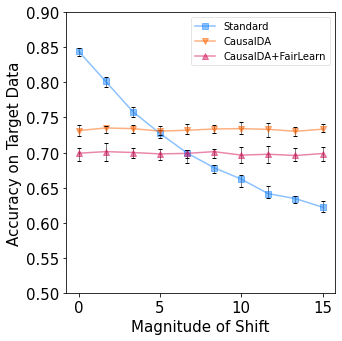

In [15]:
methods_plot = [0,1,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'acc_test', gamma_shift_tar, (0.5,0.9), 'Accuracy', '1_acc_3', OUTDIR)

Median
 [[0.11535077 0.11189412 0.11195994 0.11208272 0.10992904 0.10681518
  0.10781097 0.10687332 0.1108626  0.08981532]
 [0.26118408 0.27518542 0.30351133 0.32944287 0.32618689 0.3457639
  0.36452706 0.38201933 0.37193326 0.37505133]
 [0.02120062 0.0454364  0.07697275 0.11705528 0.15289018 0.17913749
  0.2031331  0.21718189 0.21577195 0.21909493]
 [0.01885394 0.02512085 0.02304579 0.02676959 0.03149828 0.03471362
  0.04714242 0.05212148 0.05579793 0.06610845]
 [0.02417587 0.02416211 0.02361095 0.02493625 0.03497819 0.04320157
  0.04356362 0.0529187  0.06303227 0.08399927]]


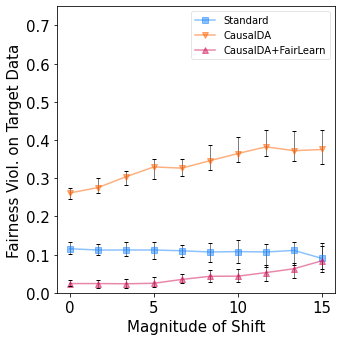

In [16]:
methods_plot = [0,1,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'maxDEOd_test', gamma_shift_tar, (0.0,0.75), 'Fairness Viol.', '1_mDEO_fair_3', OUTDIR)

## Figures 3b, 3c in main text

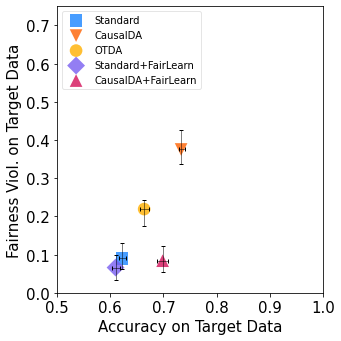

In [17]:
gamma_id = -1
# gamma_id = 6 # Uncomment when using gamma_shift_tar =  np.linspace(0,15,10) above
xylim = (0.5,1.0,0.0,0.75)
scatter_metric_fair(all_shift_res, methods, 'acc_test', 'maxDEOd_test', gamma_shift_tar[gamma_id], gamma_id, xylim, 'Accuracy', 'Fairness Viol.', 'acc_maxDEOd_high', OUTDIR)

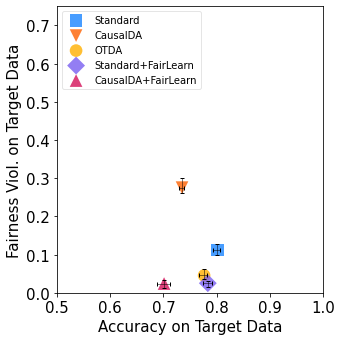

In [21]:
gamma_id = 1
# gamma_id = 6 # Uncomment when using gamma_shift_tar =  np.linspace(0,15,10) above
xylim = (0.5,1.0,0.0,0.75)
scatter_metric_fair(all_shift_res, methods, 'acc_test', 'maxDEOd_test', gamma_shift_tar[gamma_id], gamma_id, xylim, 'Accuracy', 'Fairness Viol.', 'acc_maxDEOd_high', OUTDIR)

## Figures 5a, 5b, 5c in appendix

Median
 [[0.84425 0.80125 0.75825 0.72725 0.69925 0.67825 0.662   0.64125 0.63425
  0.622  ]
 [0.73125 0.735   0.734   0.7305  0.73175 0.7335  0.734   0.733   0.73025
  0.73325]
 [0.82925 0.7765  0.7265  0.695   0.677   0.66825 0.66225 0.662   0.663
  0.66375]
 [0.82875 0.7835  0.73975 0.71125 0.681   0.66275 0.64825 0.63125 0.621
  0.61   ]
 [0.699   0.70125 0.7     0.698   0.69875 0.70125 0.69625 0.6975  0.69575
  0.6985 ]]


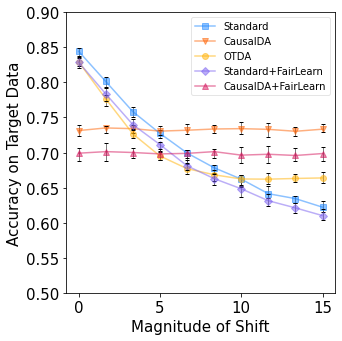

In [18]:
methods_plot = [0,1,2,3,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'acc_test', gamma_shift_tar, (0.5,0.9), 'Accuracy', 'acc', OUTDIR)

Median
 [[0.92352576 0.88322479 0.8388097  0.7994086  0.76388683 0.7367205
  0.71369213 0.6897455  0.67325308 0.65994137]
 [0.80960131 0.81039388 0.80923563 0.80367418 0.80060775 0.79593924
  0.79354123 0.78934129 0.78669702 0.7847336 ]
 [0.91242561 0.85927461 0.80571633 0.77132938 0.74710189 0.7368425
  0.73262724 0.7349017  0.7408407  0.74579736]
 [0.91343316 0.86887612 0.82358431 0.78420151 0.74976565 0.72671307
  0.70563044 0.68312004 0.66819477 0.65685434]
 [0.778236   0.78384054 0.7790967  0.77656506 0.77764015 0.77715033
  0.77581753 0.77715587 0.77579881 0.77788144]]


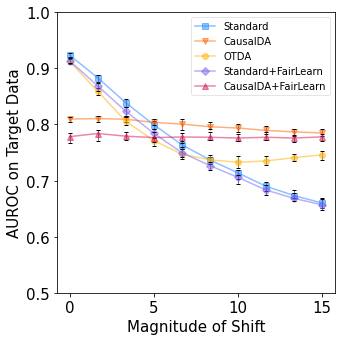

In [19]:
methods_plot = [0,1,2,3,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'roc_auc_test', gamma_shift_tar, (0.5,1.0), 'AUROC', 'roc_auc', OUTDIR)

Median
 [[0.11535077 0.11189412 0.11195994 0.11208272 0.10992904 0.10681518
  0.10781097 0.10687332 0.1108626  0.08981532]
 [0.26118408 0.27518542 0.30351133 0.32944287 0.32618689 0.3457639
  0.36452706 0.38201933 0.37193326 0.37505133]
 [0.02120062 0.0454364  0.07697275 0.11705528 0.15289018 0.17913749
  0.2031331  0.21718189 0.21577195 0.21909493]
 [0.01885394 0.02512085 0.02304579 0.02676959 0.03149828 0.03471362
  0.04714242 0.05212148 0.05579793 0.06610845]
 [0.02417587 0.02416211 0.02361095 0.02493625 0.03497819 0.04320157
  0.04356362 0.0529187  0.06303227 0.08399927]]


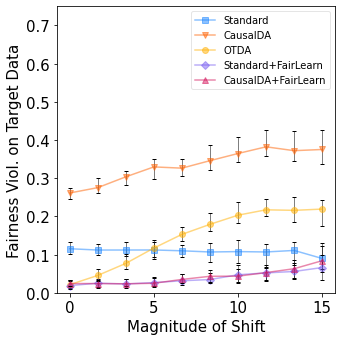

In [20]:
methods_plot = [0,1,2,3,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'maxDEOd_test', gamma_shift_tar, (0.0,0.75), 'Fairness Viol.', 'mDEO_fair', OUTDIR)